# Setting up

In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.layers import Layer, Conv2D, Input, BatchNormalization, Add, \
AveragePooling2D, MaxPooling2D, ZeroPadding2D, ReLU, Dense, Flatten, Dropout, \
Embedding, Attention, RepeatVector, Concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import datasets, layers, models, optimizers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tqdm.notebook import tqdm
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

We'll be using Flickr8K for this.

In [2]:
# Create a directory for the dataset and working
!mkdir flickr8k
!mkdir working

# Download the Flickr8k dataset
!wget --quiet https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget --quiet https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

# Unzip the dataset files into the same directory
!unzip Flickr8k_Dataset.zip -d flickr8k/ > /dev/null
!unzip Flickr8k_text.zip -d flickr8k/ > /dev/null


In [3]:
BASE_DIR = 'flickr8k'
WORKING_DIR = 'working'

**HACK** In the captions I have, there is an issue. There's an entry that it should be for the file `2258277193_586949ec62.jpg.1` on `Flickr8k.token.txt`. But the file doesn't exist at all, leading the training to error out due to the lack of the instance of the `2258277193_586949ec62.jpg.1`file.

In [4]:
import shutil

# Make a backup of the original caption file
shutil.copyfile('flickr8k/Flickr8k.token.txt', 'flickr8k/Flickr8k.token.original.txt')

# Read the original caption file
with open('flickr8k/Flickr8k.token.txt', 'r') as f:
    captions = f.readlines()

# Remove the problematic line
captions = [c for c in captions if '2258277193_586949ec62.jpg.1' not in c]

# Write the new caption file
with open('flickr8k/Flickr8k.token.txt', 'w') as f:
    f.writelines(captions)


In [5]:
print("modifed")
!grep "2258277193" "flickr8k/Flickr8k.token.txt"
print("original")
!grep "2258277193" "flickr8k/Flickr8k.token.original.txt" 

modifed
original
2258277193_586949ec62.jpg.1#0	people waiting for the subway
2258277193_586949ec62.jpg.1#1	Some people looking out windows in a large building .
2258277193_586949ec62.jpg.1#2	Three people are waiting on a train platform .
2258277193_586949ec62.jpg.1#3	Three people standing at a station .
2258277193_586949ec62.jpg.1#4	two woman and one man standing near train tracks .


# ResNet50Revamp


In [6]:
# load resnetv2 model
model = ResNet50V2()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
#print(model.summary())

102869336/102869336 [==============================] - 3s 0us/step


In [7]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Flicker8k_Dataset')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [8]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [9]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [10]:
with open(os.path.join(BASE_DIR, 'Flickr8k.token.txt'), 'r') as f:
    captions_doc = f.read()

In [11]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by hashtag/pound
    tokens = line.split('#')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [12]:
len(mapping)

8091

In [13]:
features['1000268201_693b08cb0e'].shape

(1, 2048)

In [14]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [15]:
# before preprocess of text
mapping['1000268201_693b08cb0e']
# preprocess the text
clean(mapping)
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [16]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
len(all_captions)
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8485

In [18]:
# get maximum length, based on the longest one
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [19]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [20]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [21]:
# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
image_features = RepeatVector(max_length)(fe2)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
seq_features = LSTM(256, return_sequences=True)(se2)

# attention mechanism
attention = Attention()([image_features, seq_features])
context_vector = Concatenate(axis=-1)([seq_features, attention])

# decoder model
decoder1 = LSTM(256)(context_vector)
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# tie everything together
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [22]:
# encoder model
# image feature layers
inputs1 = Input(shape=(2048,), name="image_input")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text_input")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


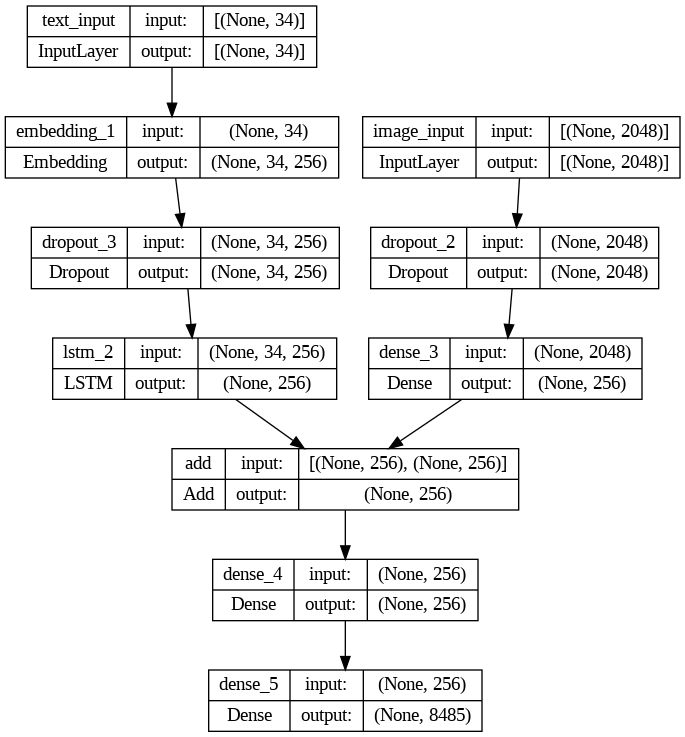

In [23]:

# plot the model
plot_model(model, show_shapes=True)

In [24]:
# train the model
epochs = 10
batch_size = 32
steps = len(train) // batch_size

generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
history = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/10
227/227 [==============================] - 79s 322ms/step - loss: 5.2722
Epoch 2/10
227/227 [==============================] - 63s 276ms/step - loss: 4.0491
Epoch 3/10
227/227 [==============================] - 61s 268ms/step - loss: 3.6279
Epoch 4/10
227/227 [==============================] - 60s 264ms/step - loss: 3.3778
Epoch 5/10
227/227 [==============================] - 61s 267ms/step - loss: 3.1862
Epoch 6/10
227/227 [==============================] - 61s 267ms/step - loss: 3.0314
Epoch 7/10
227/227 [==============================] - 60s 263ms/step - loss: 2.9026
Epoch 8/10
227/227 [==============================] - 60s 262ms/step - loss: 2.7988
Epoch 9/10
227/227 [==============================] - 60s 264ms/step - loss: 2.7101
Epoch 10/10
227/227 [==============================] - 60s 263ms/step - loss: 2.6330


In [25]:
# save the model
model.save(WORKING_DIR+'/model_rn50.h5')

# Eval

In [26]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [27]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [28]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

In [29]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

  0%|          | 0/810 [00:00<?, ?it/s]

In [30]:
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.2, 0.3, 0.5, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.552419
BLEU-2: 0.326963
BLEU-3: 0.151401
BLEU-4: 0.120574


In [31]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Flicker8k_Dataset", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    print("BLEU-1: %f" % sentence_bleu(captions, y_pred, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % sentence_bleu(captions, y_pred,  weights=(0.5, 0.5, 0, 0)))
    print("BLEU-3: %f" % sentence_bleu(captions, y_pred,  weights=(0.2, 0.3, 0.5, 0)))
    print("BLEU-4: %f" % sentence_bleu(captions, y_pred,  weights=(0.25, 0.25, 0.25, 0.25)))
    plt.figure()
    plt.imshow(image)

In [32]:
def gen_rand_cap():
    id = np.random.randint(0,len(mapping))
    filepaths = os.listdir(BASE_DIR +"/Flicker8k_Dataset")
    sample_path = filepaths[id] 
    generate_caption(sample_path)

---------------------Actual---------------------
startseq baby clutching stuffed animal is smiling endseq
startseq little girl in fleecy jacket holds stuffed animal and smiles endseq
startseq little girl in white jacket holding piglet toy endseq
startseq little girl is wearing winter coat and holding stuffed animal in one hand endseq
startseq young girl holding stuffed pig smiles endseq
--------------------Predicted--------------------
startseq baby in red and white flowers endseq
BLEU-1: 0.837128
BLEU-2: 0.788130
BLEU-3: 0.685523
BLEU-4: 0.657417


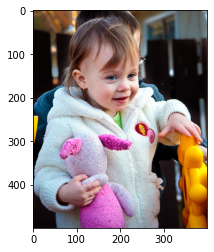

In [33]:
gen_rand_cap()

In [34]:
from nltk.translate.bleu_score import sentence_bleu
import os

def calculate_accuracy(model, features, tokenizer, max_length, num_images=None):
    total_bleu_score = 0
    count = 0
    if num_images is None:
        num_images = len(features)
    else:
        num_images = min(num_images, len(features))


    for i in range(num_images):
        # Load the image
        image_name = image_id + ".jpg"
        img_path = os.path.join(BASE_DIR, "Flicker8k_Dataset", image_name)
        image = Image.open(img_path)

        # Get the ground truth captions for this image
        captions = mapping[image_id]

        # Generate the predicted caption
        y_pred = predict_caption(model, feature, tokenizer, max_length)

        # Calculate the BLEU score for the predicted caption
        bleu_score = sentence_bleu(captions, y_pred)
        
        # Add the BLEU score to the total
        total_bleu_score += bleu_score

    # Calculate the average BLEU score
    average_bleu_score = total_bleu_score / num_images

    # Print the final results
    print(f"Average BLEU Score: {average_bleu_score:.4f}")

In [35]:
calculate_accuracy(model, features, tokenizer, max_length, num_images=10)

Average BLEU Score: 0.4926
